## 线性回归梯度下降算法

线性回归的梯度下降算法有三种:

* 批量梯度下降(Batch Gradient Descent)
* 随机梯度下降(Stochastic Gradient Descent)
* 小批量梯度下降(Mini-batch Gradient Descent)

下面我们对这三种梯度下降算法进行实验对比。

### 准备数据

为了便于直观绘图，我们选择只有一个特征的线性样本。预测值 $y$ 和特征 $x$ 的关系如下：

$$ y = 3x + 4 + 噪音 $$

如果不考虑噪音，通过线性回归，应该得到：$\theta_0=4，\theta_1=3$。

下面画出所有样本点 $(x^{i}, y^{i})$：

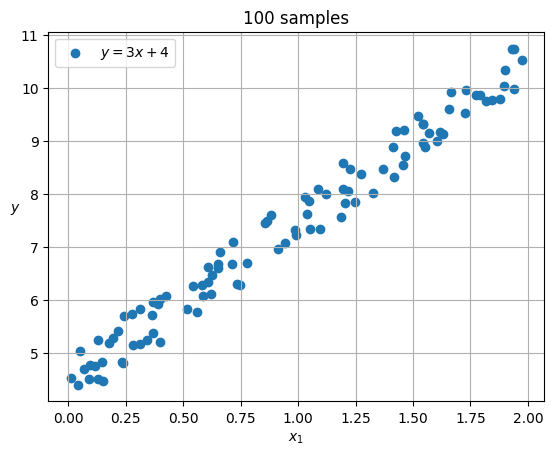

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import add_dummy_feature

np.random.seed(42)

# 100个训练数据
X1_train = 2 * np.random.rand(100, 1)
y_train = 4 + 3 * X1_train + np.random.rand(100, 1)
X_train = X_b = add_dummy_feature(X1_train) # 给特征值添加x0维度

# 2个测试数据
X1_test = np.array([[0], [2]])
X_test = add_dummy_feature(X1_test)

fig, ax = plt.subplots()
ax.scatter(X_train[:,1], y_train, label='$y=3x+4$')
ax.set_title("100 samples")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y$", rotation=0)
ax.legend()
ax.grid()

theta_init = np.random.randn(2, 1) # 初始参数theta，通过每次迭代进行修正

### 批量梯度下降

批量梯度下降每次迭代都需要对所有样本点计算损失函数的偏导数，公式如下：

$$\bigtriangledown_{\theta} MSE(\theta) = \begin{pmatrix}
\frac{\partial}{\partial \theta_0}MSE(\theta)\\ 
\frac{\partial}{\partial \theta_1}MSE(\theta)\\ 
...\\ 
\frac{\partial}{\partial \theta_n}MSE(\theta)\\ 
\end{pmatrix} = \frac{2}{m}X^T \cdot (X \cdot \theta - y)$$

同时，可以选择不同的学习率 $\eta$，以控制迭代的速率。

$$ \theta^{(next step)} = \theta - \eta \bigtriangledown_{\theta} MSE(\theta)$$

下面我们选择三个学习率(0.02, 0.1, 0.5)，对比批量梯度下降在不同学习率下的迭代情况：

BGD: eta=0.02, y=4.51x+2.98
BGD: eta=0.1, y=4.51x+2.98
BGD: eta=0.5, y=-8.36e+27x+-9.46e+27


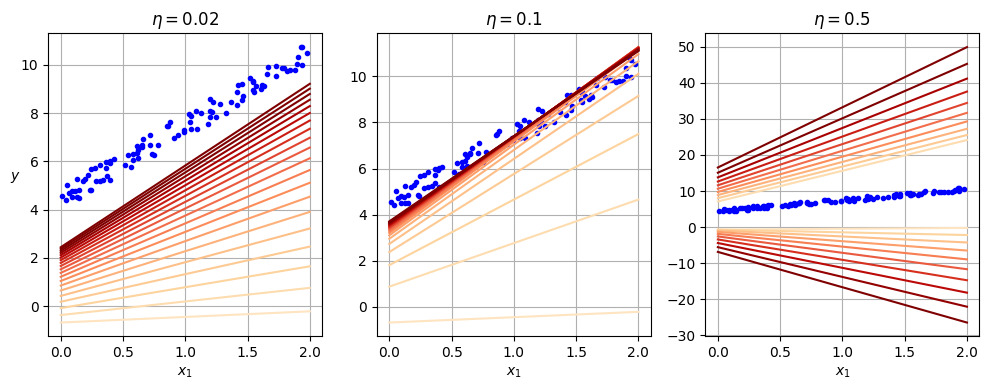

In [12]:
np.random.seed(42)

# 训练样本 (X_train, y_train)
# 测试样本 (X_test, y_test)
def BGDRegression(eta):
    theta = theta_init
    m = len(X_train) # 样本数
    max_iter = 1000
    n_shown = 20 # 显示前几次的迭代结果

    plt.plot(X_train[:,1], y_train, "b.") # 训练样本
    theta_path = [theta]
    for i in range(max_iter):
        if i < n_shown:
            y_pred = X_test @ theta # y = theta1 * x1 + theta0
            color = mpl.colors.rgb2hex(plt.cm.OrRd(i / n_shown + 0.15))
            plt.plot(X_test[:,1], y_pred, linestyle="solid", color=color)
        gradients = 2 / m * X_train.T @ (X_b @ theta - y_train) # 计算损失函数的偏导数
        theta = theta - eta * gradients # 结合学习率调整theta值
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(131)
theta_path_bgd_small = BGDRegression(eta=0.02)
ax1.set_ylabel("$y$", rotation=0)
theta0 = round(theta_path_bgd_small[-1][0][0], 2)
theta1 = round(theta_path_bgd_small[-1][1][0], 2)
print(f'BGD: eta=0.02, y={theta0}x+{theta1}')

ax2 = plt.subplot(132)
theta_path_bgd = BGDRegression(eta=0.1)
theta0 = round(theta_path_bgd[-1][0][0], 2)
theta1 = round(theta_path_bgd[-1][1][0], 2)
print(f'BGD: eta=0.1, y={theta0}x+{theta1}')

ax3 = plt.subplot(133)
theta_path_bgd_large = BGDRegression(eta=0.5)
theta0 = round(theta_path_bgd_large[-1][0][0], 2)
theta1 = round(theta_path_bgd_large[-1][1][0], 2)
print(f'BGD: eta=0.5, y={theta0:.3}x+{theta1:.3}')

fig.tight_layout()

### 随机梯度下降

随机梯度下降(SGD)每次迭代随机选取一个样本点用于损失函数偏导数的计算，以减少计算量。因此，每次迭代的公式如下(不同于批量梯度下降，不需要除以 $m$)：

$$\bigtriangledown_{\theta} MSE(\theta) = 2X^T \cdot (X \cdot \theta - y)$$

$$ \theta^{(next step)} = \theta - \eta \bigtriangledown_{\theta} MSE(\theta)$$

为了保证最终收敛到极值，学习率随着迭代次数的增大逐步减小。下面的代码，通过`learning_schedule`求得学习率：

SGD: y=4.52x+2.98


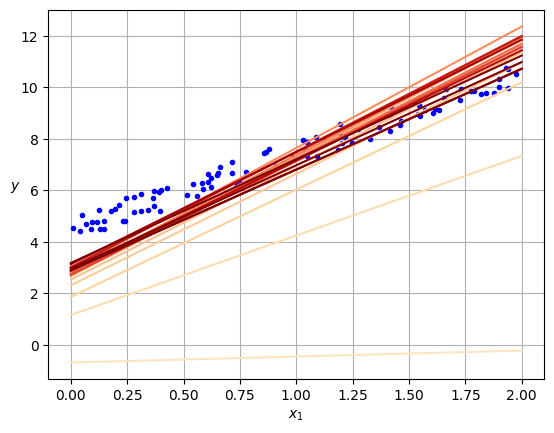

In [13]:
np.random.seed(42)

# 决定每次迭代的学习的函数，逐渐降低学习率
def learning_schedule(t):
    # 随机梯度下降的超参数，用于控制学习率
    t0, t1 = 5, 50
    return t0 / (t + t1)

# 训练样本 (X_train, y_train)
# 测试样本 (X_test, y_test)
def SGDRegression():
    theta = theta_init
    m = len(X_train) # 样本数
    max_iter = 50
    n_shown = 20 # 显示前几次的迭代结果

    plt.plot(X_train[:,1], y_train, "b.") # 训练样本
    theta_path = [theta]
    for i in range(max_iter):
        for j in range(m): # 每次迭代随机选取一个采样点
            if i == 0 and j < n_shown:
                y_pred = X_test @ theta # y = theta1 * x1 + theta0
                color = mpl.colors.rgb2hex(plt.cm.OrRd(j / n_shown + 0.15))
                plt.plot(X_test[:,1], y_pred, linestyle="solid", color=color)

            # 此处不同与批量梯度下降算法，随机选取一个采样点用于迭代计算
            random_index = np.random.randint(m)
            xj = X_train[random_index : random_index + 1]
            yj = y_train[random_index : random_index + 1]
            gradients = 2 * xj.T @ (xj @ theta - yj) # 此处无需除以m
            eta = learning_schedule(i * m + j) # 随着迭代次数的增大，学习率逐渐减小
            theta = theta - eta * gradients # 结合学习率调整theta值
            theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.grid()
    return theta_path

theta_path_sgd = SGDRegression()
theta0 = round(theta_path_sgd[-1][0][0], 2)
theta1 = round(theta_path_sgd[-1][1][0], 2)
print(f'SGD: y={theta0}x+{theta1}')


### 小批量梯度下降

小批量梯度下降，顾名思义，每次迭代选取一部分样本点用于计算。因此，其计算量介于批量梯度下降和随机梯度下降之间。

Mini-BGD: y=4.53x+3.0


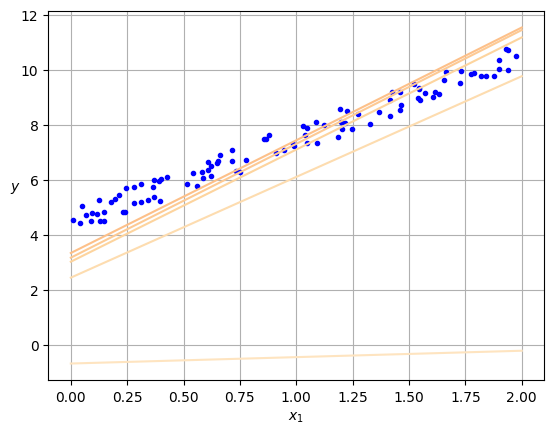

In [14]:
from math import ceil

np.random.seed(42)

# 决定每次迭代的学习的函数，逐渐降低学习率
def learning_schedule(t):
    # 随机梯度下降的超参数，用于控制学习率
    t0, t1 = 200, 1000
    return t0 / (t + t1)

# 训练样本 (X_train, y_train)
# 测试样本 (X_test, y_test)
def MGDRegression():
    theta = theta_init
    m = len(X_train) # 样本数
    minibatch_size = 20
    n_batches_per_iter = ceil(m / minibatch_size)
    max_iter = 50
    n_shown = 20 # 显示前几次的迭代结果

    plt.plot(X_train[:,1], y_train, "b.") # 训练样本
    theta_path = [theta]
    for i in range(max_iter):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]
        for j in range(0, n_batches_per_iter):
            if i == 0 and j < n_shown:
                y_pred = X_test @ theta # y = theta1 * x1 + theta0
                color = mpl.colors.rgb2hex(plt.cm.OrRd(j / n_shown + 0.15))
                plt.plot(X_test[:,1], y_pred, linestyle="solid", color=color)

            idx = j * minibatch_size
            xj = X_shuffled[idx : idx + minibatch_size]
            yj = y_shuffled[idx : idx + minibatch_size]
            gradients = 2 / minibatch_size * xj.T @ (xj @ theta - yj)
            eta = learning_schedule(j)
            theta = theta - eta * gradients # 结合学习率调整theta值
            theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.grid()
    return theta_path

theta_path_mgd = MGDRegression()
theta0 = round(theta_path_mgd[-1][0][0], 2)
theta1 = round(theta_path_mgd[-1][1][0], 2)
print(f'Mini-BGD: y={theta0}x+{theta1}')

### 总结

分别对比三种梯度下降算法，下面的代码绘制出了每次迭代后 $\theta$ 值的变化情况：

Text(0, 0.5, '$\\theta_1$')

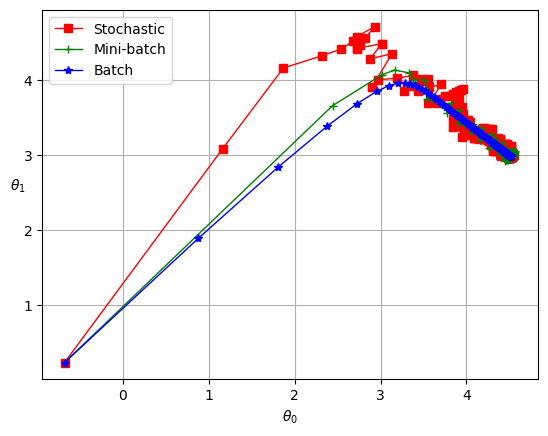

In [15]:
np.random.seed(42)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

fig = plt.figure()

ax = plt.subplot()
ax.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
ax.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=1, label="Mini-batch")
ax.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-*", linewidth=1, label="Batch")

ax.legend()
ax.grid()
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$", rotation=0)